# MNIST & Fashion-MNIST: Mirror Descent vs SGD Analysis

This notebook provides comprehensive analysis comparing Mirror Descent (MD) and SGD performance on MNIST and Fashion-MNIST datasets, including:
- Grouped bar chart comparison
- Alpha parameter sensitivity analysis
- Block size sensitivity analysis
- Hyperparameter heatmaps

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wandb import Api

In [38]:
# Setup plotting style
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 150
})

# Define colors
colors = {
    'SGD': '#1f77b4',  # Blue
    'MD': '#ff7f0e',   # Orange
    'MNIST': '#2ca02c', # Green
    'Fashion': '#d62728' # Red
}

print("✅ Setup complete!")

✅ Setup complete!


In [39]:
# Load data from WandB
api = Api(timeout=120)
ENTITY = "hp-learning-rules"

def load_clean_data(project_name):
    """Load and clean WandB data"""
    print(f"Loading {project_name}...")
    runs = api.runs(f"{ENTITY}/{project_name}", filters={"state": "finished"})
    
    data = []
    for run in runs:
        row = {'run_id': run.id, 'name': run.name}
        
        # Add config data
        if run.config:
            for key, value in run.config.items():
                row[f'config_{key}'] = value
                
        # Add summary data
        if run.summary:
            for key, value in run.summary.items():
                row[f'summary_{key}'] = value
                
        data.append(row)
    
    df = pd.DataFrame(data)
    
    # Clean and standardize optimizer names
    if 'config_optimizer.update' in df.columns:
        df['optimizer'] = df['config_optimizer.update'].str.upper().replace({'GD': 'SGD'})
    
    print(f"  ✅ Loaded {len(df)} runs")
    return df

In [5]:
# Load datasets
mnist_df = load_clean_data("big-mnist")
fashion_df = load_clean_data("big-fashion_mnist")

# Add dataset labels
mnist_df['dataset'] = 'MNIST'
fashion_df['dataset'] = 'Fashion-MNIST'

print(f"\n📊 Data loaded successfully!")
print(f"MNIST: {len(mnist_df)} runs, Fashion-MNIST: {len(fashion_df)} runs")

Loading big-mnist...
  ✅ Loaded 296 runs
Loading big-fashion_mnist...
  ✅ Loaded 296 runs

📊 Data loaded successfully!
MNIST: 296 runs, Fashion-MNIST: 296 runs


In [9]:
mnist_df.columns

Index(['run_id', 'name', 'config_data.dataset', 'config_logging.tags',
       'config_optimizer.lr', 'config_optimizer.wd', 'config_data.data_path',
       'config_logging.folder', 'config_data.batch_size',
       'config_logging.disable', 'config_optimizer.alpha',
       'config_training.epochs', 'config_model.input_size',
       'config_optimizer.update', 'config_logging.frequency',
       'config_model.output_size', 'config_model.hidden_size1',
       'config_model.hidden_size2', 'config_model.hidden_size3',
       'config_logging.log_updates', 'config_optimizer.block_size',
       'config_logging.wandb_project', 'config_logging.checkpoint_path',
       'summary__runtime', 'summary__step', 'summary__timestamp',
       'summary__wandb', 'summary_average_cancel_ratio', 'summary_epoch',
       'summary_fc1.weight_L1_norm', 'summary_fc1.weight_L2_norm',
       'summary_fc1.weight_cancel_ratio', 'summary_fc1.weight_histogram',
       'summary_fc2.weight_L1_norm', 'summary_fc2.weight_L2_n

## 2. Alpha Parameter Analysis

Scatter plots and heatmaps showing how the alpha parameter affects MD performance.

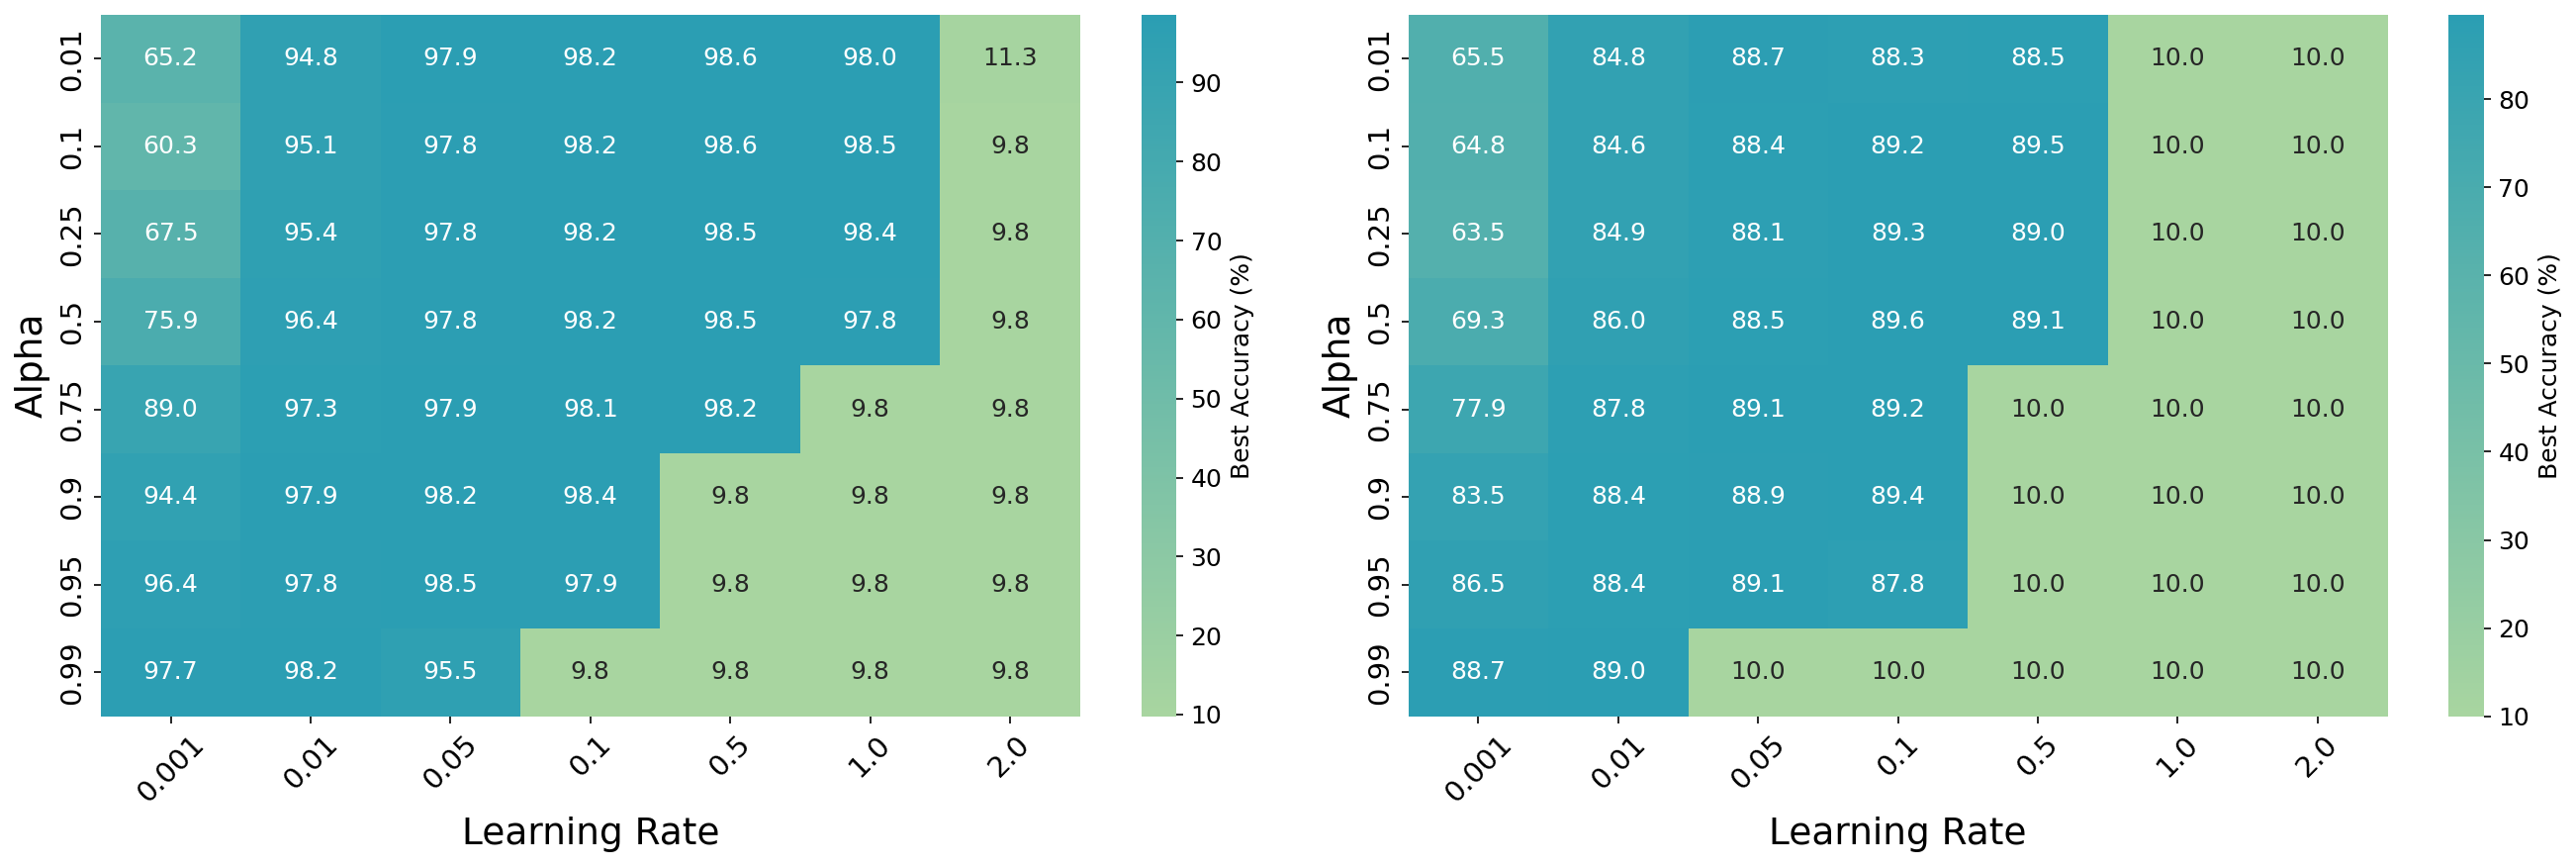

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# define your green-blue colormap
colors = {
    'SGD':     '#5fad56',
    'MD':      '#2b9eb3',
    'SGD+Mom': '#0b6e4f',
    'MD+Mom':  '#084c61'
}
lighter_green = "#a8d5a0"
greenblue_cmap = LinearSegmentedColormap.from_list(
    "greenblue_custom", [lighter_green, colors['MD']]
)

def create_alpha_heatmap_analysis(mnist_data, fashion_data):
    """Create heatmaps showing MD alpha × learning rate performance"""
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # one row, two panels
    
    datasets = [('MNIST', mnist_data), ('Fashion-MNIST', fashion_data)]
    
    for col, (dataset_name, data) in enumerate(datasets):
        # Filter for MD runs
        md_data = data[
            (data['optimizer'] == 'MD') & 
            data['summary_test_accuracy'].notna() & 
            data['config_optimizer.alpha'].notna() & 
            data['config_optimizer.lr'].notna()
        ].copy()
        
        # Exclude lr=5.0
        md_data = md_data[md_data['config_optimizer.lr'] != 5.0]
        
        if len(md_data) > 0:
            # Pivot table (alpha × lr → best accuracy)
            pivot_data = md_data.pivot_table(
                values='summary_test_accuracy',
                index='config_optimizer.alpha',
                columns='config_optimizer.lr',
                aggfunc='max'
            ).sort_index(ascending=True)
            
            # Plot heatmap
            sns.heatmap(
                pivot_data, annot=True, fmt='.1f',
                cmap=greenblue_cmap, ax=axes[col],
                cbar_kws={'label': 'Best Accuracy (%)'}
            )
            
            axes[col].set_xlabel('Learning Rate', fontsize=18)
            axes[col].set_ylabel('Alpha', fontsize=18)
            # axes[col].set_title(f'{dataset_name}: MD Hyperparameter Grid',
            #                     fontsize=16, pad=12)
            axes[col].tick_params(axis='x', labelrotation=45, labelsize=14)
            axes[col].tick_params(axis='y', labelsize=14)
        
    # plt.suptitle('Mirror Descent: Alpha × Learning Rate Robustness',
    #              fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Run it
# print("🎯 Creating alpha heatmap analysis...")
fig2 = create_alpha_heatmap_analysis(mnist_df, fashion_df)
plt.show()

🎯 Creating alpha parameter analysis...
\nMNIST - Alpha Analysis:
  α= 0.0: Best= 98.6%, Mean= 71.3%, n=32
  α= 0.1: Best= 98.6%, Mean= 70.6%, n=32
  α= 0.2: Best= 98.5%, Mean= 68.2%, n=32
  α= 0.5: Best= 98.5%, Mean= 67.1%, n=32
  α= 0.8: Best= 98.2%, Mean= 63.3%, n=32
  α= 0.9: Best= 98.4%, Mean= 53.2%, n=32
  α= 0.9: Best= 98.5%, Mean= 50.7%, n=32
  α= 1.0: Best= 98.2%, Mean= 34.4%, n=32
\nFashion-MNIST - Alpha Analysis:
  α= 0.0: Best= 88.7%, Mean= 55.3%, n=32
  α= 0.1: Best= 89.5%, Mean= 55.4%, n=32
  α= 0.2: Best= 89.3%, Mean= 50.5%, n=32
  α= 0.5: Best= 89.6%, Mean= 51.1%, n=32
  α= 0.8: Best= 89.2%, Mean= 47.6%, n=32
  α= 0.9: Best= 89.4%, Mean= 48.5%, n=32
  α= 0.9: Best= 89.1%, Mean= 43.7%, n=32
  α= 1.0: Best= 89.0%, Mean= 27.0%, n=32


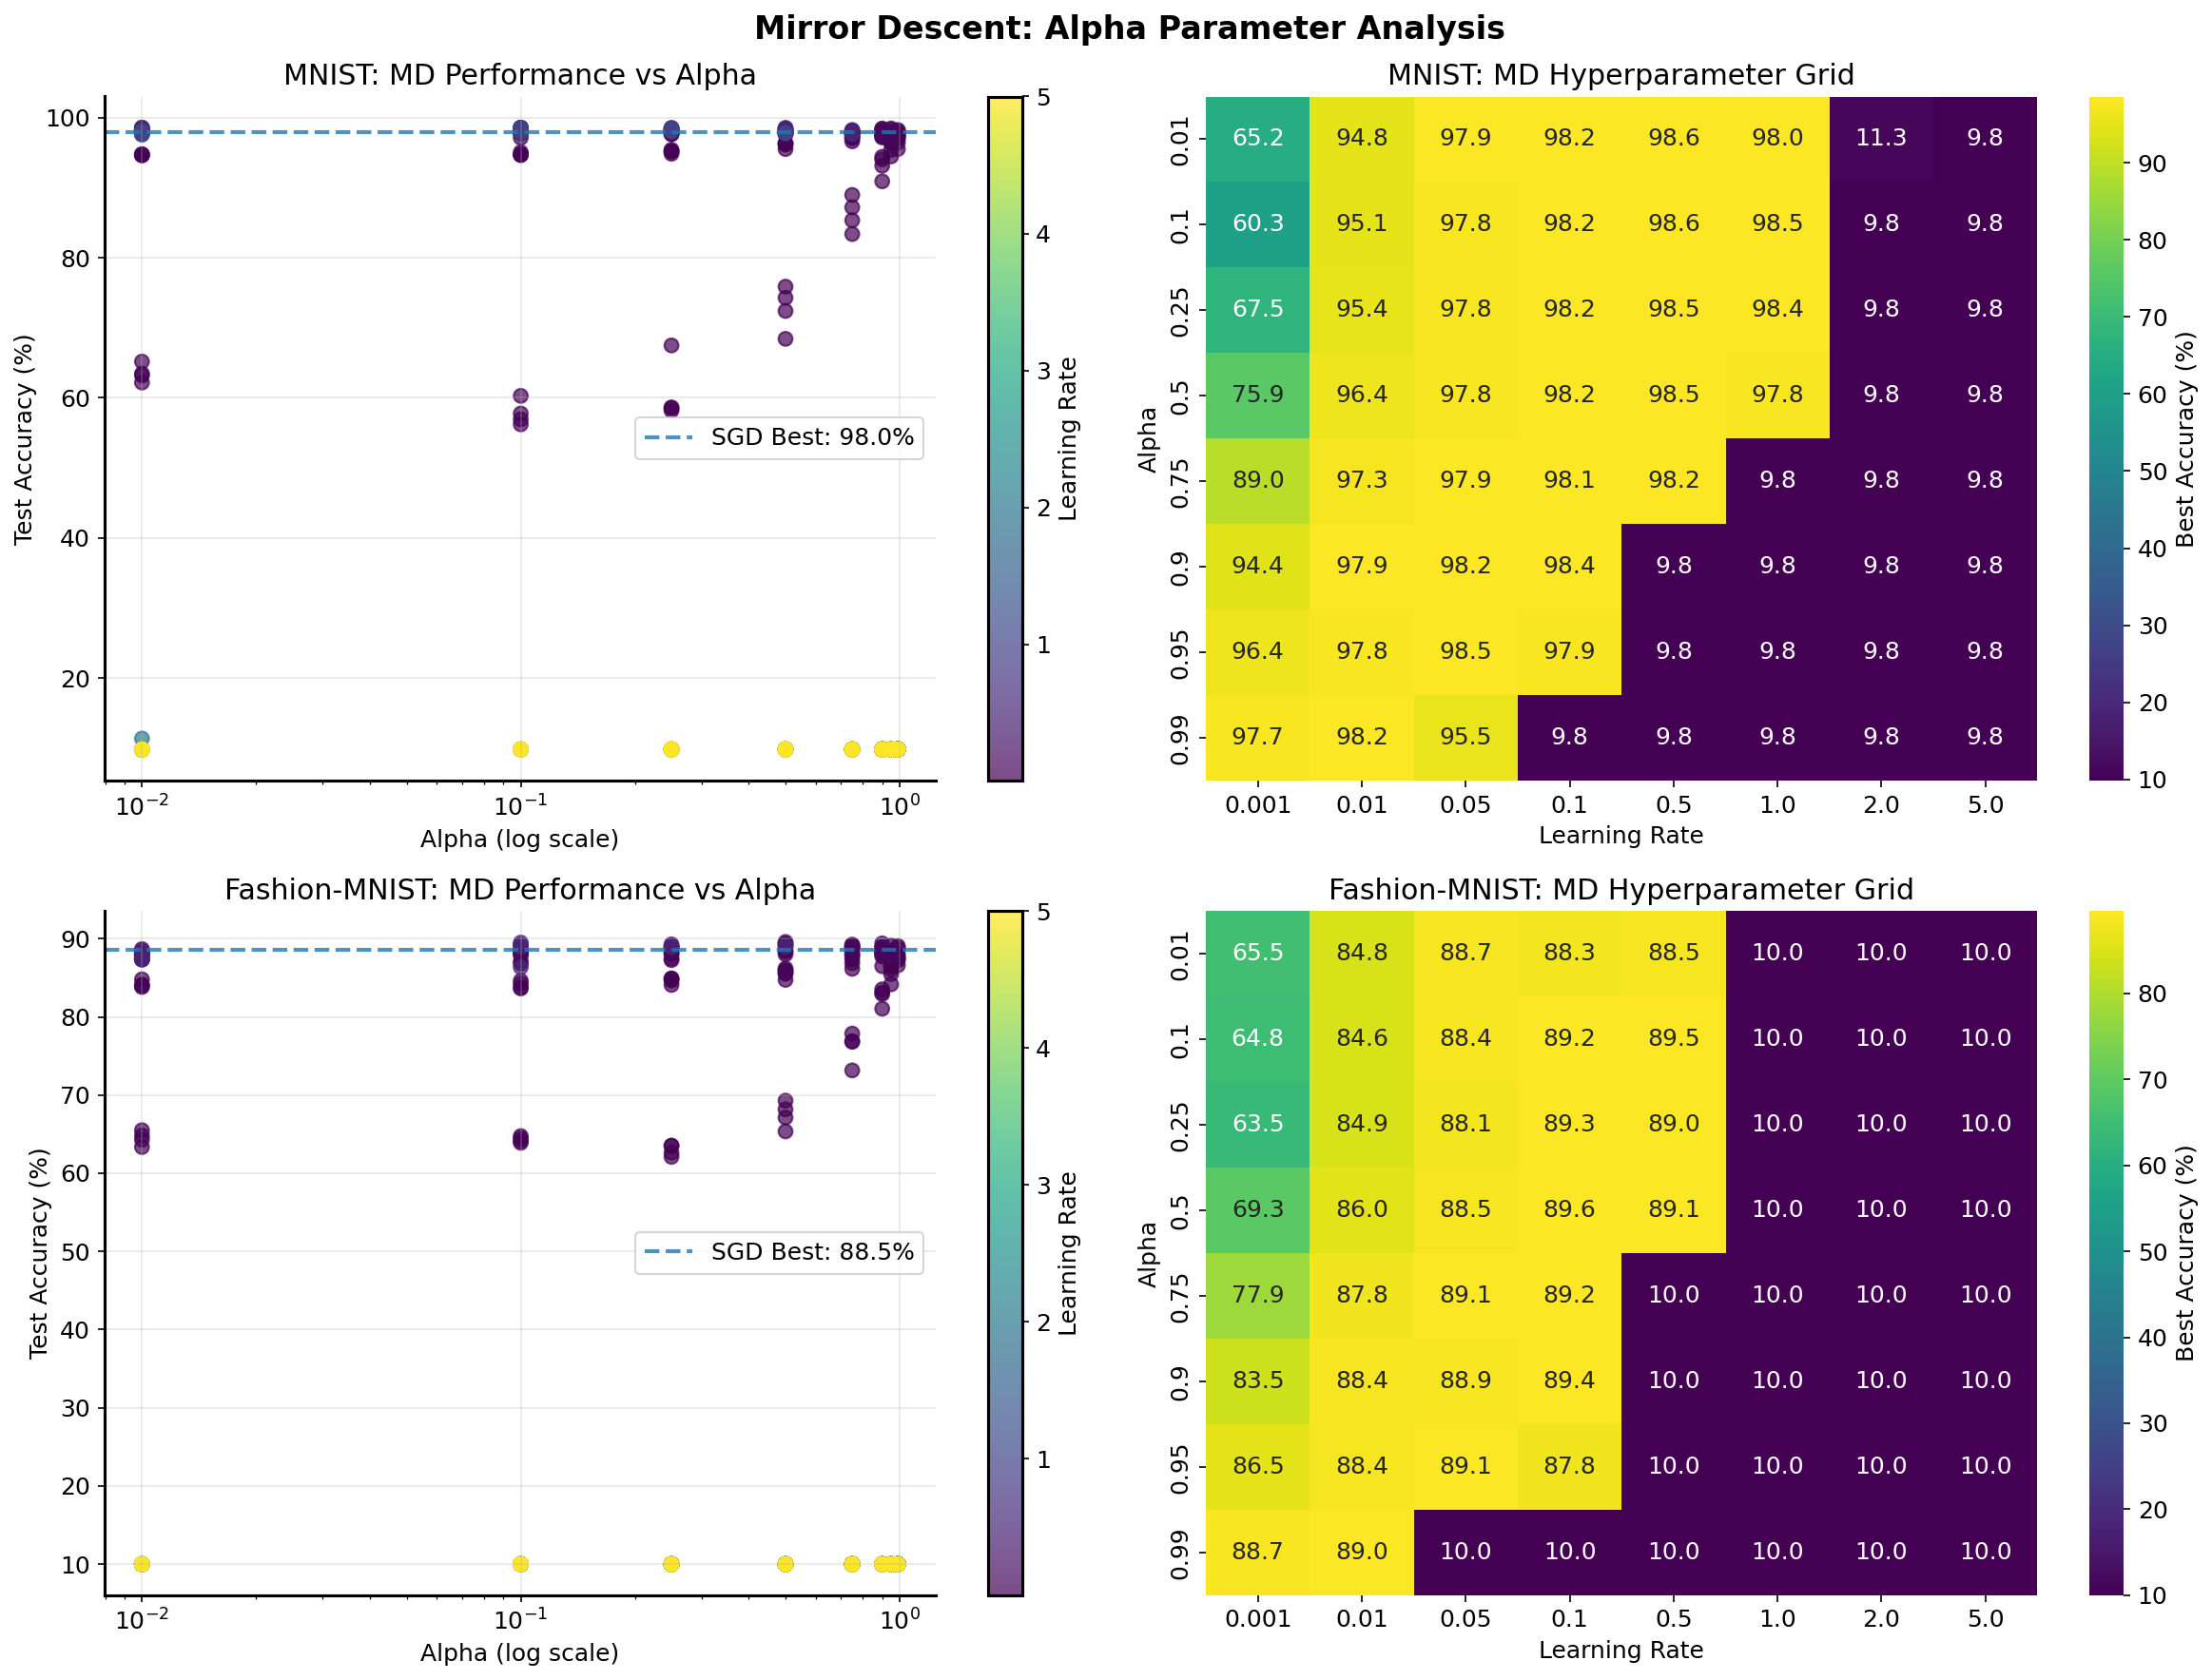

In [8]:
def create_alpha_scatter_analysis(mnist_data, fashion_data):
    """Create scatter plots showing alpha parameter effects"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    datasets = [('MNIST', mnist_data), ('Fashion-MNIST', fashion_data)]
    
    for row, (dataset_name, data) in enumerate(datasets):
        # Filter for MD data with valid alpha and lr
        md_data = data[
            (data['optimizer'] == 'MD') & 
            data['summary_test_accuracy'].notna() & 
            data['config_optimizer.alpha'].notna() & 
            data['config_optimizer.lr'].notna()
        ].copy()
        
        # Get SGD baseline
        sgd_data = data[
            (data['optimizer'] == 'SGD') & 
            data['summary_test_accuracy'].notna()
        ]
        
        if len(sgd_data) > 0:
            sgd_best = sgd_data['summary_test_accuracy'].max()
        else:
            sgd_best = None
        
        # Scatter plot: Alpha vs Accuracy colored by LR
        ax1 = axes[row, 0]
        
        if len(md_data) > 0:
            scatter = ax1.scatter(md_data['config_optimizer.alpha'], 
                                md_data['summary_test_accuracy'],
                                c=md_data['config_optimizer.lr'], 
                                cmap='viridis', alpha=0.7, s=50)
            
            ax1.set_xscale('log')
            plt.colorbar(scatter, ax=ax1, label='Learning Rate')
            
            # Add SGD baseline
            if sgd_best:
                ax1.axhline(y=sgd_best, color=colors['SGD'], linestyle='--', 
                           alpha=0.8, linewidth=2, label=f'SGD Best: {sgd_best:.1f}%')
                ax1.legend()
        
        ax1.set_xlabel('Alpha (log scale)')
        ax1.set_ylabel('Test Accuracy (%)')
        ax1.set_title(f'{dataset_name}: MD Performance vs Alpha')
        ax1.grid(True, alpha=0.3)
        
        # Heatmap: Alpha vs Learning Rate
        ax2 = axes[row, 1]
        
        if len(md_data) > 0:
            # Create pivot table for heatmap
            pivot_data = md_data.pivot_table(
                values='summary_test_accuracy',
                index='config_optimizer.alpha',
                columns='config_optimizer.lr',
                aggfunc='max'
            )
            
            # Create heatmap
            sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='viridis',
                       ax=ax2, cbar_kws={'label': 'Best Accuracy (%)'})
            
            ax2.set_xlabel('Learning Rate')
            ax2.set_ylabel('Alpha')
            ax2.set_title(f'{dataset_name}: MD Hyperparameter Grid')
        
        # Print alpha analysis
        if len(md_data) > 0:
            print(f"\\n{dataset_name} - Alpha Analysis:")
            alpha_analysis = md_data.groupby('config_optimizer.alpha')['summary_test_accuracy'].agg(['max', 'mean', 'count'])
            for alpha, stats in alpha_analysis.iterrows():
                print(f"  α={alpha:4.1f}: Best={stats['max']:5.1f}%, Mean={stats['mean']:5.1f}%, n={stats['count']:2.0f}")
    
    plt.suptitle('Mirror Descent: Alpha Parameter Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Create scatter analysis
print("🎯 Creating alpha parameter analysis...")
fig2 = create_alpha_scatter_analysis(mnist_df, fashion_df)
plt.show()

## 3. Block Size Sensitivity Analysis

Analysis of how block size parameter affects MD performance.

🔲 Creating block size sensitivity analysis...
\nMNIST - Block Size Analysis:
  Block   2: Best= 98.6%, Mean= 59.4% ± 42.1%
  Block   4: Best= 98.5%, Mean= 60.8% ± 42.0%
  Block   6: Best= 98.6%, Mean= 58.2% ± 42.5%
  Block   8: Best= 98.6%, Mean= 61.1% ± 42.2%
\nFashion-MNIST - Block Size Analysis:
  Block   2: Best= 89.3%, Mean= 46.8% ± 37.5%
  Block   4: Best= 89.4%, Mean= 48.2% ± 37.7%
  Block   6: Best= 89.5%, Mean= 47.2% ± 37.9%
  Block   8: Best= 89.6%, Mean= 47.3% ± 38.0%


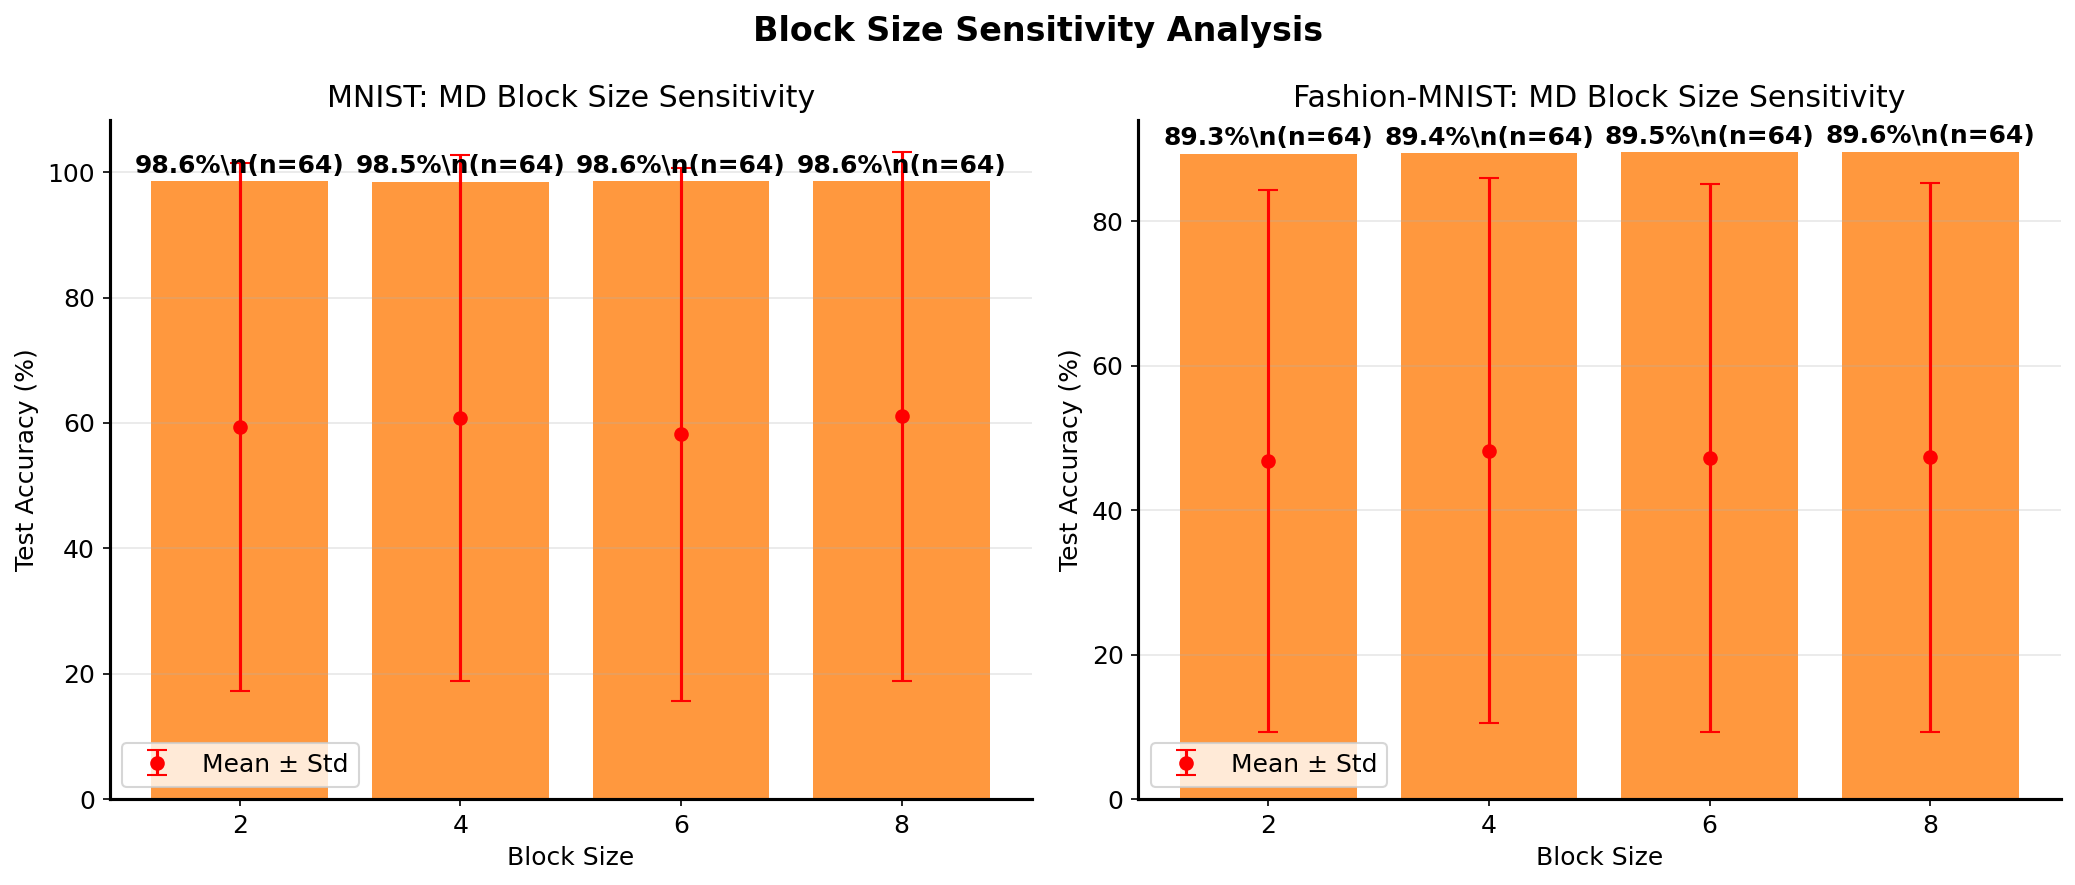

In [9]:
def analyze_block_size_sensitivity(mnist_data, fashion_data):
    """Analyze block size parameter sensitivity"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    datasets = [('MNIST', mnist_data, axes[0]), ('Fashion-MNIST', fashion_data, axes[1])]
    
    for dataset_name, data, ax in datasets:
        # Check if block_size data exists
        if 'config_optimizer.block_size' in data.columns:
            valid_data = data[
                data['summary_test_accuracy'].notna() & 
                data['config_optimizer.block_size'].notna() &
                (data['optimizer'] == 'MD')
            ].copy()
            
            if len(valid_data) > 0:
                # Group by block size and get statistics
                block_analysis = valid_data.groupby('config_optimizer.block_size')['summary_test_accuracy'].agg(['max', 'mean', 'std', 'count'])
                
                # Create bar plot
                x_pos = range(len(block_analysis.index))
                bars = ax.bar(x_pos, block_analysis['max'], alpha=0.8, color=colors['MD'])
                
                # Add error bars for mean ± std
                ax.errorbar(x_pos, block_analysis['mean'], yerr=block_analysis['std'], 
                           fmt='ro', capsize=5, label='Mean ± Std')
                
                # Add value labels
                for i, (bar, max_val, count) in enumerate(zip(bars, block_analysis['max'], block_analysis['count'])):
                    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                           f'{max_val:.1f}%\\n(n={count})', ha='center', va='bottom', fontweight='bold')
                
                ax.set_xlabel('Block Size')
                ax.set_ylabel('Test Accuracy (%)')
                ax.set_title(f'{dataset_name}: MD Block Size Sensitivity')
                ax.set_xticks(x_pos)
                ax.set_xticklabels(block_analysis.index)
                ax.legend()
                ax.grid(True, alpha=0.3, axis='y')
                
                print(f"\\n{dataset_name} - Block Size Analysis:")
                for block_size, stats in block_analysis.iterrows():
                    print(f"  Block {block_size:3.0f}: Best={stats['max']:5.1f}%, Mean={stats['mean']:5.1f}% ± {stats['std']:4.1f}%")
            else:
                ax.text(0.5, 0.5, f'No block size data\\nfor {dataset_name}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
        else:
            ax.text(0.5, 0.5, f'No block size data\\navailable', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    plt.suptitle('Block Size Sensitivity Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Create block size analysis
print("🔲 Creating block size sensitivity analysis...")
fig3 = analyze_block_size_sensitivity(mnist_df, fashion_df)
plt.show()

[warn] Missing top runs for one optimizer.
[warn] Missing top runs for one optimizer.


## 4. Save Figures

Save all generated plots as PNG and PDF files.

In [ ]:
# Save all figures
print("💾 Saving figures...")

# Save grouped bar chart
fig1.savefig('mnist_fashion_grouped_comparison.png', dpi=300, bbox_inches='tight')
fig1.savefig('mnist_fashion_grouped_comparison.pdf', bbox_inches='tight')

# Save alpha analysis
fig2.savefig('mnist_fashion_alpha_analysis.png', dpi=300, bbox_inches='tight')
fig2.savefig('mnist_fashion_alpha_analysis.pdf', bbox_inches='tight')

# Save block size analysis
fig3.savefig('mnist_fashion_blocksize_analysis.png', dpi=300, bbox_inches='tight')
fig3.savefig('mnist_fashion_blocksize_analysis.pdf', bbox_inches='tight')

print("✅ All analyses complete! Files saved as PNG and PDF.")